In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Data Collection
import yfinance as yf  # For sector returns data
import wrds  # For macroeconomic data (if using WRDS)
from fredapi import Fred  # For macroeconomic indicators from FRED (alternative)

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Statistical Analysis and Optimization
from scipy.stats import linregress  # For basic statistical analysis
from scipy.optimize import minimize  # Optional, for advanced modeling

# User Interface (Optional)
import streamlit as st

# Additional Tools
import os
import warnings
warnings.filterwarnings('ignore')
from fuzzywuzzy import fuzz, process  # Optional, for string matching

# Optional: For advanced statistical or regression analysis
import statsmodels.api as sm


In [2]:
# Define sector ETFs
sector_etfs = {
    'Technology': 'XLK',
    'Financials': 'XLF',
    'Energy': 'XLE',
    'Healthcare': 'XLV',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Utilities': 'XLU',
    'Materials': 'XLB',
    'Industrials': 'XLI',
    'Real Estate': 'XLRE'
}

# Download historical data
sector_prices = {}
for sector, ticker in sector_etfs.items():
    sector_prices[sector] = yf.download(ticker, start='2000-01-01')['Adj Close']

# Combine into a DataFrame
sector_prices_df = pd.DataFrame(sector_prices)

# Calculate monthly returns
sector_monthly_returns = sector_prices_df.resample('M').ffill().pct_change()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Initialize with your API key
fred = Fred(api_key='89eca7ea9c367afe440cdc634912e3dd')

# Fetch GDP growth data
gdp_growth = fred.get_series('A191RL1Q225SBEA')  # Quarterly real GDP growth
unemployment_rate = fred.get_series('UNRATE')  # Monthly unemployment rate
interest_rate = fred.get_series('DGS10')  # 10-year Treasury yield
cpi = fred.get_series('CPIAUCSL')  # Monthly CPI

# Combine FRED data into a DataFrame
fred_data = pd.DataFrame({
    'GDP Growth': gdp_growth,
    'Unemployment Rate': unemployment_rate,
    'Interest Rate': interest_rate,
    'CPI': cpi
})

# Calculate CPI growth (inflation rate)
fred_data['Inflation Rate'] = fred_data['CPI'].pct_change() * 100
fred_data.drop(columns=['CPI'], inplace=True)
fred_data = fred_data.resample('M').mean()

In [4]:
# Step 3: Define the classify_sector Function
def classify_sector(sic):
    """
    Map SIC codes to industry sectors.
    """
    if 1000 <= sic <= 1999:
        return 'Technology'
    elif 2000 <= sic <= 2999:
        return 'Materials'
    elif 3000 <= sic <= 3999:
        return 'Industrials'
    elif 4000 <= sic <= 4999:
        return 'Utilities'
    elif 5000 <= sic <= 5999:
        return 'Consumer Staples'
    elif 6000 <= sic <= 6999:
        return 'Financials'
    elif 7000 <= sic <= 7999:
        return 'Real Estate'
    elif 8000 <= sic <= 8999:
        return 'Healthcare'
    elif 9000 <= sic <= 9999:
        return 'Energy'
    else:
        return 'Unknown'

In [5]:
# Step 3: Fetch Sector Data from CRSP via WRDS
db = wrds.Connection()

# Fetch CRSP data for stock-level returns and SIC codes
crsp_data = db.raw_sql("""
    SELECT date, ret, hsiccd
    FROM crsp.dsf
    WHERE date >= '2000-01-01' AND ret IS NOT NULL
""")

# Convert date to datetime and group by SIC codes
crsp_data['date'] = pd.to_datetime(crsp_data['date'])
crsp_data['Sector'] = crsp_data['hsiccd'].apply(classify_sector)  # Define `classify_sector` to map SIC codes to sectors

# Aggregate CRSP returns by sector and date
crsp_sector_returns = crsp_data.groupby(['date', 'Sector'])['ret'].mean().unstack()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [6]:
# Step 5: Combine Sector Data (CRSP and YFinance)
# Merge CRSP sector returns and ETF sector returns
sector_returns_combined = sector_monthly_returns.merge(
    crsp_sector_returns, left_index=True, right_index=True, how='outer', suffixes=('_ETF', '_CRSP')
)

In [7]:
# Step 6: Combine Macro Data with Sector Returns
# Filter macro data to match the date range of sector data
combined_data = sector_returns_combined.merge(fred_data, left_index=True, right_index=True, how='inner')


In [8]:
# Step 7: Label Economic Cycles
def label_cycles(row):
    # Use safe defaults if GDP Growth or Unemployment Rate is missing
    if pd.isna(row['GDP Growth']) or pd.isna(row['Unemployment Rate']):
        return 'Unknown'

    # Label as Expansion or Contraction
    if row['GDP Growth'] > 0 and row['Unemployment Rate'] < combined_data['Unemployment Rate'].mean():
        return 'Expansion'
    elif row['GDP Growth'] <= 0:
        return 'Contraction'
    else:
        return 'Neutral'

combined_data['Economic Cycle'] = combined_data.apply(label_cycles, axis=1)
print(combined_data['Economic Cycle'].unique())  # Verify the labels again


['Expansion' 'Unknown' 'Contraction' 'Neutral']


In [9]:
# Define the base sector names
base_sectors = list(sector_etfs.keys())

# Identify ETF columns
etf_columns = [col for col in combined_data.columns if '_ETF' in col]

# Identify CRSP columns
crsp_columns = [col for col in combined_data.columns if '_CRSP' in col]

# Identify combined sector columns (ETF and CRSP)
sector_columns = etf_columns + crsp_columns

# Check identified columns
print("ETF Columns:", etf_columns)
print("CRSP Columns:", crsp_columns)
print("Combined Sector Columns:", sector_columns)

ETF Columns: ['Technology_ETF', 'Financials_ETF', 'Energy_ETF', 'Healthcare_ETF', 'Consumer Staples_ETF', 'Utilities_ETF', 'Materials_ETF', 'Industrials_ETF', 'Real Estate_ETF']
CRSP Columns: ['Consumer Staples_CRSP', 'Energy_CRSP', 'Financials_CRSP', 'Healthcare_CRSP', 'Industrials_CRSP', 'Materials_CRSP', 'Real Estate_CRSP', 'Technology_CRSP', 'Utilities_CRSP']
Combined Sector Columns: ['Technology_ETF', 'Financials_ETF', 'Energy_ETF', 'Healthcare_ETF', 'Consumer Staples_ETF', 'Utilities_ETF', 'Materials_ETF', 'Industrials_ETF', 'Real Estate_ETF', 'Consumer Staples_CRSP', 'Energy_CRSP', 'Financials_CRSP', 'Healthcare_CRSP', 'Industrials_CRSP', 'Materials_CRSP', 'Real Estate_CRSP', 'Technology_CRSP', 'Utilities_CRSP']


### ETF-Based Performance

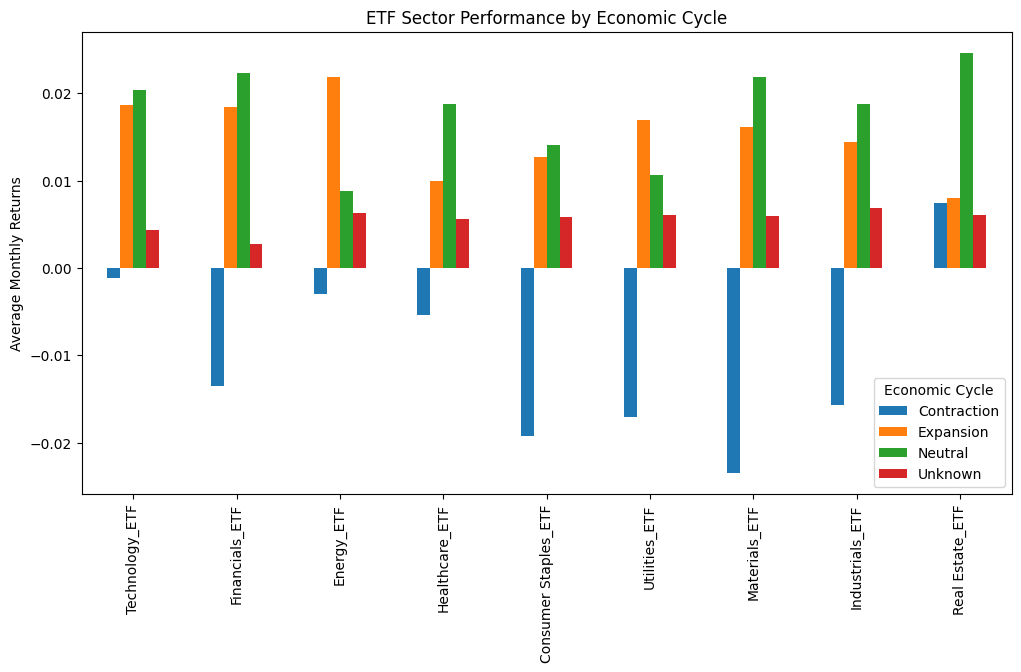

ETF Sector Performance:
                Technology_ETF  Financials_ETF  Energy_ETF  Healthcare_ETF  \
Economic Cycle                                                               
Contraction          -0.001187       -0.013556   -0.003008       -0.005427   
Expansion             0.018606        0.018429    0.021825        0.009994   
Neutral               0.020405        0.022338    0.008765        0.018744   
Unknown               0.004362        0.002718    0.006289        0.005578   

                Consumer Staples_ETF  Utilities_ETF  Materials_ETF  \
Economic Cycle                                                       
Contraction                -0.019260      -0.017089      -0.023425   
Expansion                   0.012636       0.016970       0.016068   
Neutral                     0.014109       0.010641       0.021848   
Unknown                     0.005840       0.006054       0.005978   

                Industrials_ETF  Real Estate_ETF  
Economic Cycle                     

In [10]:
# Analyze ETF sector performance
etf_performance = combined_data.groupby('Economic Cycle')[etf_columns].mean()

# Plot ETF sector performance
etf_performance.T.plot(kind='bar', figsize=(12, 6))
plt.title('ETF Sector Performance by Economic Cycle')
plt.ylabel('Average Monthly Returns')
plt.show()

print("ETF Sector Performance:")
print(etf_performance)


### CRSP-Based Analysis

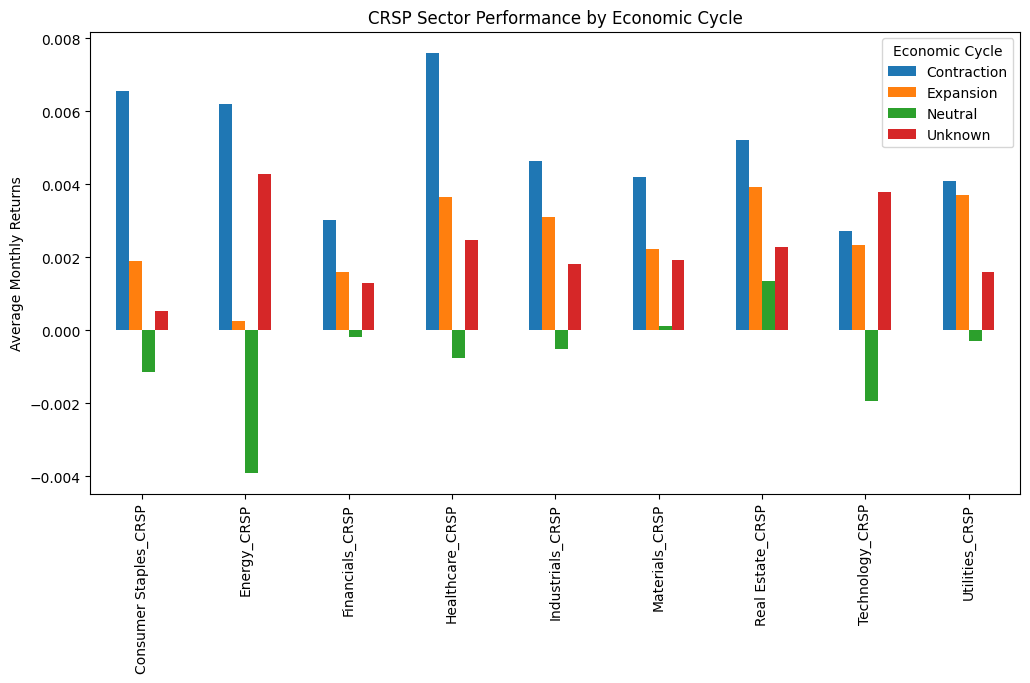

CRSP Sector Performance:
                Consumer Staples_CRSP  Energy_CRSP  Financials_CRSP  \
Economic Cycle                                                        
Contraction                  0.006547     0.006207         0.003029   
Expansion                    0.001897     0.000244         0.001595   
Neutral                     -0.001155    -0.003896        -0.000179   
Unknown                      0.000516     0.004278         0.001295   

                Healthcare_CRSP  Industrials_CRSP  Materials_CRSP  \
Economic Cycle                                                      
Contraction            0.007611          0.004651        0.004194   
Expansion              0.003654          0.003098        0.002229   
Neutral               -0.000753         -0.000500        0.000118   
Unknown                0.002464          0.001808        0.001933   

                Real Estate_CRSP  Technology_CRSP  Utilities_CRSP  
Economic Cycle                                                   

In [11]:
# Analyze CRSP sector performance
crsp_performance = combined_data.groupby('Economic Cycle')[crsp_columns].mean()

# Plot CRSP sector performance
crsp_performance.T.plot(kind='bar', figsize=(12, 6))
plt.title('CRSP Sector Performance by Economic Cycle')
plt.ylabel('Average Monthly Returns')
plt.show()

print("CRSP Sector Performance:")
print(crsp_performance)


### Combined Analysis

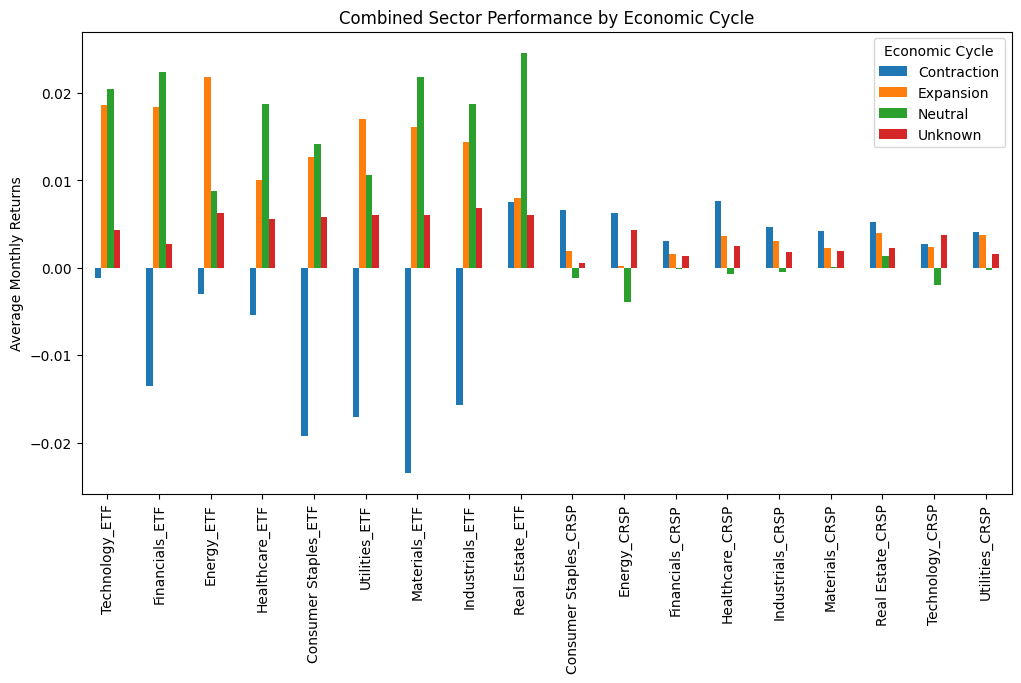

Combined Sector Performance:
                Technology_ETF  Financials_ETF  Energy_ETF  Healthcare_ETF  \
Economic Cycle                                                               
Contraction          -0.001187       -0.013556   -0.003008       -0.005427   
Expansion             0.018606        0.018429    0.021825        0.009994   
Neutral               0.020405        0.022338    0.008765        0.018744   
Unknown               0.004362        0.002718    0.006289        0.005578   

                Consumer Staples_ETF  Utilities_ETF  Materials_ETF  \
Economic Cycle                                                       
Contraction                -0.019260      -0.017089      -0.023425   
Expansion                   0.012636       0.016970       0.016068   
Neutral                     0.014109       0.010641       0.021848   
Unknown                     0.005840       0.006054       0.005978   

                Industrials_ETF  Real Estate_ETF  Consumer Staples_CRSP  \
Econom

In [12]:
# Analyze combined sector performance (ETF + CRSP)
combined_performance = combined_data.groupby('Economic Cycle')[sector_columns].mean()

# Plot combined sector performance
combined_performance.T.plot(kind='bar', figsize=(12, 6))
plt.title('Combined Sector Performance by Economic Cycle')
plt.ylabel('Average Monthly Returns')
plt.show()

print("Combined Sector Performance:")
print(combined_performance)


### Generate Insights

In [13]:
# Best sectors during Expansion and Contraction for ETFs
best_expansion_etf = etf_performance.loc['Expansion'].idxmax()
best_contraction_etf = etf_performance.loc['Contraction'].idxmax()

# Best sectors during Expansion and Contraction for CRSP
best_expansion_crsp = crsp_performance.loc['Expansion'].idxmax()
best_contraction_crsp = crsp_performance.loc['Contraction'].idxmax()

# Best sectors during Expansion and Contraction for Combined
best_expansion_combined = combined_performance.loc['Expansion'].idxmax()
best_contraction_combined = combined_performance.loc['Contraction'].idxmax()

print(f"Best ETF sector during Expansion: {best_expansion_etf}")
print(f"Best ETF sector during Contraction: {best_contraction_etf}")
print(f"Best CRSP sector during Expansion: {best_expansion_crsp}")
print(f"Best CRSP sector during Contraction: {best_contraction_crsp}")
print(f"Best Combined sector during Expansion: {best_expansion_combined}")
print(f"Best Combined sector during Contraction: {best_contraction_combined}")


Best ETF sector during Expansion: Energy_ETF
Best ETF sector during Contraction: Real Estate_ETF
Best CRSP sector during Expansion: Real Estate_CRSP
Best CRSP sector during Contraction: Healthcare_CRSP
Best Combined sector during Expansion: Energy_ETF
Best Combined sector during Contraction: Healthcare_CRSP


In [14]:
# Calculate volatility by economic cycle
sector_volatility = combined_data.groupby('Economic Cycle')[sector_columns].std()

# Identify most and least volatile sectors
most_volatile = sector_volatility.idxmax(axis=1)
least_volatile = sector_volatility.idxmin(axis=1)


In [15]:
risk_free_rate = 0.005  # Example monthly risk-free rate

# Calculate Sharpe Ratio
sector_sharpe = (combined_performance - risk_free_rate) / sector_volatility

# Identify best sector by Sharpe Ratio
best_sharpe = sector_sharpe.idxmax(axis=1)


In [16]:
macro_columns = ['GDP Growth', 'Unemployment Rate', 'Interest Rate', 'Inflation Rate']
sector_columns = [col for col in combined_data.columns if '_ETF' in col or '_CRSP' in col]

# Correlation of macro indicators with sector returns
macro_correlation = combined_data[macro_columns + sector_columns].corr()

# Filter for macro-sector correlations
macro_to_sector_corr = macro_correlation.loc[macro_columns, sector_columns]

# Display the correlation matrix
print(macro_to_sector_corr)


                   Technology_ETF  Financials_ETF  Energy_ETF  Healthcare_ETF  \
GDP Growth               0.034619        0.116686   -0.133827        0.007268   
Unemployment Rate        0.112169        0.069816    0.079719        0.135555   
Interest Rate           -0.160313       -0.042921    0.005766       -0.123985   
Inflation Rate           0.015998        0.060308    0.142565        0.031771   

                   Consumer Staples_ETF  Utilities_ETF  Materials_ETF  \
GDP Growth                     0.179444       0.209958       0.119471   
Unemployment Rate              0.101789       0.014082       0.124644   
Interest Rate                 -0.068031      -0.018401      -0.054394   
Inflation Rate                 0.007349       0.003153       0.032094   

                   Industrials_ETF  Real Estate_ETF  Consumer Staples_CRSP  \
GDP Growth                0.123581        -0.030057              -0.036293   
Unemployment Rate         0.109300         0.168497              -0.1030

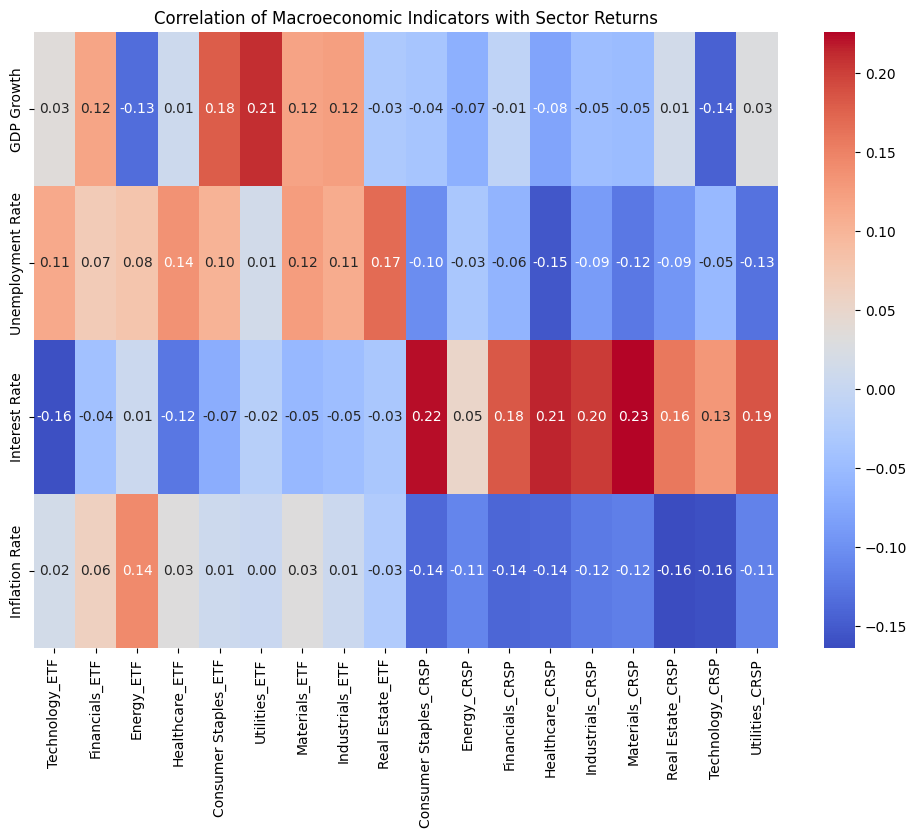

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(macro_to_sector_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Macroeconomic Indicators with Sector Returns")
plt.show()


In [18]:
import plotly.express as px

# Create a long-form DataFrame for Plotly
long_data = combined_data.melt(id_vars=['Economic Cycle'], value_vars=sector_columns, 
                               var_name='Sector', value_name='Return')

# Plot grouped bar chart
fig = px.bar(long_data, x='Sector', y='Return', color='Economic Cycle', barmode='group')


Best-performing sectors for each economic cycle:
{'Contraction': 'Healthcare_CRSP', 'Expansion': 'Energy_ETF', 'Neutral': 'Real Estate_ETF', 'Unknown': 'Industrials_ETF'}


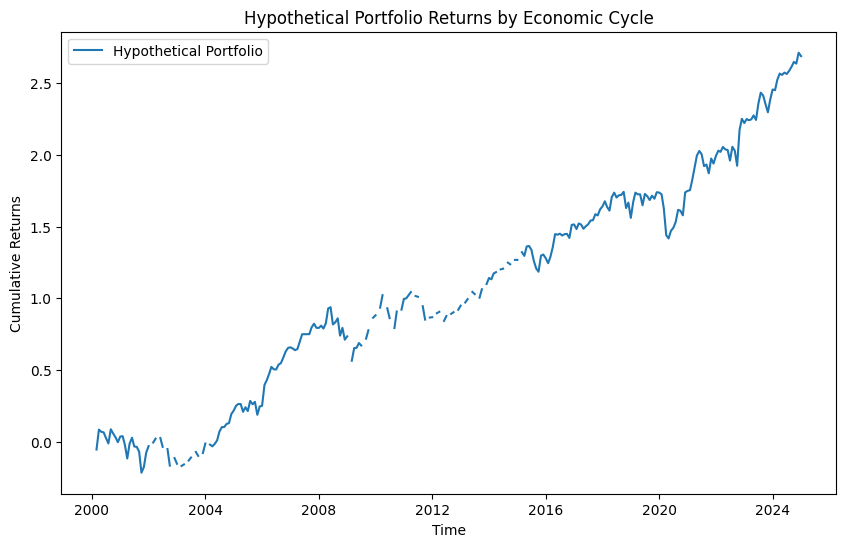

In [19]:
# Calculate the best-performing sector for each economic cycle
best_sectors = combined_data.groupby('Economic Cycle')[sector_columns].mean().idxmax(axis=1).to_dict()

print("Best-performing sectors for each economic cycle:")
print(best_sectors)

# Calculate hypothetical portfolio returns
portfolio_returns = combined_data.apply(
    lambda row: row[best_sectors[row['Economic Cycle']]] if row['Economic Cycle'] in best_sectors else 0,
    axis=1
).cumsum()

# Plot the portfolio returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns, label='Hypothetical Portfolio')
plt.title('Hypothetical Portfolio Returns by Economic Cycle')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [22]:
# Extract dates and economic cycles
economic_cycles = combined_data[['Economic Cycle']].copy()
economic_cycles['Cycle Code'] = economic_cycles['Economic Cycle'].map({
    'Expansion': 1,
    'Neutral': 0,
    'Contraction': -1,
    'Unknown': None  # Optional: Exclude "Unknown" if not needed
})

# Ensure no missing values for plotting
economic_cycles.dropna(subset=['Cycle Code'], inplace=True)


In [24]:
# Define ETF and CRSP sector columns
etf_columns = [col for col in combined_data.columns if '_ETF' in col]
crsp_columns = [col for col in combined_data.columns if '_CRSP' in col]

# Save ETF and CRSP columns to the CSV file (as metadata)
metadata = {
    'ETF Columns': etf_columns,
    'CRSP Columns': crsp_columns
}

# Save combined_data to a CSV with all columns
combined_data.to_csv('combined_data.csv', index=True)
print("Data successfully saved with the following columns:")
print(combined_data.columns)


Data successfully saved with the following columns:
Index(['Technology_ETF', 'Financials_ETF', 'Energy_ETF', 'Healthcare_ETF',
       'Consumer Discretionary', 'Consumer Staples_ETF', 'Utilities_ETF',
       'Materials_ETF', 'Industrials_ETF', 'Real Estate_ETF',
       'Consumer Staples_CRSP', 'Energy_CRSP', 'Financials_CRSP',
       'Healthcare_CRSP', 'Industrials_CRSP', 'Materials_CRSP',
       'Real Estate_CRSP', 'Technology_CRSP', 'Unknown', 'Utilities_CRSP',
       'GDP Growth', 'Unemployment Rate', 'Interest Rate', 'Inflation Rate',
       'Economic Cycle'],
      dtype='object')


In [21]:
print("ETF Columns:", etf_columns)

ETF Columns: ['Technology_ETF', 'Financials_ETF', 'Energy_ETF', 'Healthcare_ETF', 'Consumer Staples_ETF', 'Utilities_ETF', 'Materials_ETF', 'Industrials_ETF', 'Real Estate_ETF']
